In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization,Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import librosa
from librosa import display
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/Shareddrives/DS_Project/genres_original/')

Mounted at /content/drive


In [ ]:
blues=[]
classical=[]
country=[]
disco=[]
hiphop=[]
jazz=[]
metal=[]
reggae=[]
rock=[]
pop=[]

blues = os.listdir('blues')
classical = os.listdir('classical')
country = os.listdir('country')
disco = os.listdir('disco')
hiphop = os.listdir('hiphop')
jazz = os.listdir('jazz')
metal = os.listdir('metal')
reggae = os.listdir('reggae')
rock = os.listdir('rock')
pop = os.listdir('pop')

names_list = ['classical', 'reggae', 'jazz', 'pop', 'country', 'rock', 'blues', 'disco', 'metal', 'hiphop']
list=[classical, reggae, jazz, pop, country, rock, blues, disco, metal, hiphop]
extracted_features=[]

**SPLITTING AUDIO FILES**

In [ ]:
for g in names_list:
  path_audio = os.path.join('audio3sec',f'{g}')
  os.makedirs(path_audio)

In [ ]:
from pydub import AudioSegment
r=0
for i in list:
    k=0
    for j in i:
        for w in range(0,10):
          t1 = 3*(w)*1000
          t2 = 3*(w+1)*1000
          newAudio = AudioSegment.from_wav(names_list[r]+'/'+j)
          new = newAudio[t1:t2]
          new.export(f'audio3sec/{names_list[r]}/{names_list[r]+str(k)+str(w)}.wav', format="wav")
          k=k+1
    r+=1

**DATA VISUALIZATION**

In [ ]:
os.chdir('audio3sec/')
!dir

blues	   country  hiphop  metal	  model.h5  reggae
classical  disco    jazz    model_cnn.h5  pop	    rock


**PLOTTING LIBROSA AUDIO DATA**

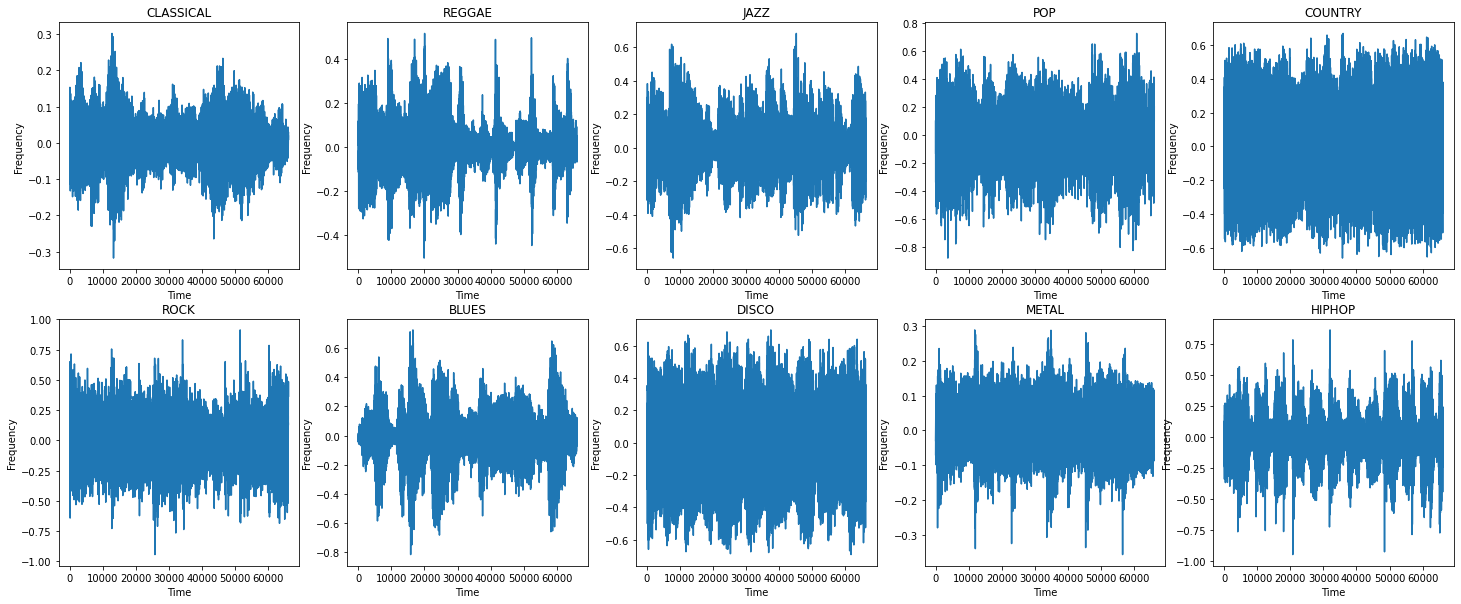

In [ ]:
fig = plt.figure(figsize=(25, 10))
rows = 2
columns = 5
r=0
for i in list:
    fig.add_subplot(rows, columns, r+1)
    audio, sample_rate = librosa.load(names_list[r]+'/'+names_list[r]+'00.wav', duration=3) 
    plt.plot(audio)
    plt.axis('on')
    plt.title(names_list[r].upper())
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    r+=1


**MEL SPECTOGRAMS**

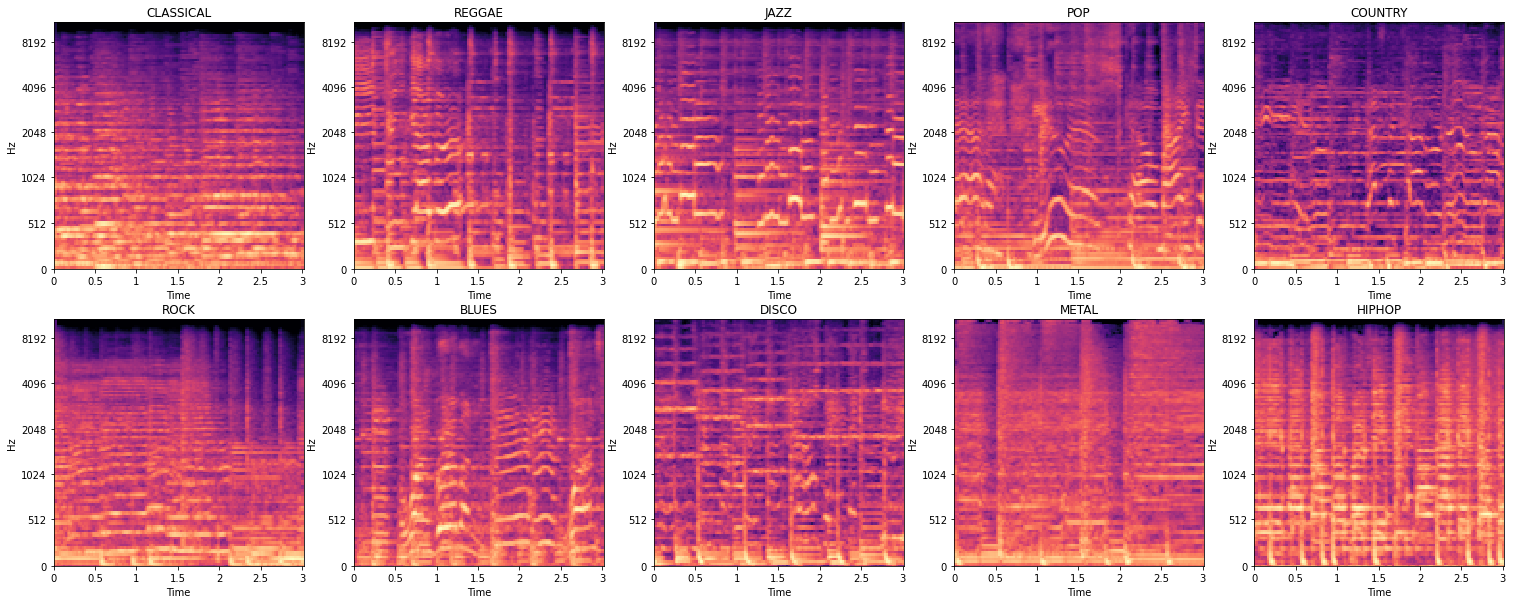

In [ ]:
fig = plt.figure(figsize=(26, 10))
rows = 2
columns = 5
r=0
for i in list:
    fig.add_subplot(rows, columns, r+1)
    audio, sample_rate = librosa.load(names_list[r]+'/'+names_list[r]+'00.wav', duration=3) 
    mels = librosa.feature.melspectrogram(y=audio,sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(mels,ref=np.max), sr=sample_rate, x_axis='time', y_axis='mel')
    plt.title(names_list[r].upper())
    r+=1

**FEATURE EXTRACTION**

In [ ]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate,n_mfcc=128)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [ ]:
r=0
for i in list:
    for j in i:
        data=features_extractor(names_list[r]+'/'+j)
        extracted_features.append([data,r])
    r+=1

In [ ]:
df=pd.DataFrame(extracted_features,columns=['feature','class'])
df.head()

,feature,class
0,"[-234.12454, 154.71829, -23.60695, 42.822445, ...",0
1,"[-210.71451, 140.35942, -32.42588, 48.86866, -...",0
2,"[-233.92653, 139.60173, -31.878891, 44.74876, ...",0
3,"[-239.93224, 143.65727, -37.81184, 46.44946, -...",0
4,"[-429.32434, 139.55867, -42.327778, 25.138895,...",0


**DATA SPLITTING**

In [ ]:
X=np.array(df['feature'].tolist())
y=np.array(df['class'].tolist())

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=0)

In [ ]:
X_train.shape

(7992, 128)

**DEEP NEURAL NETWORK**

In [ ]:
model=Sequential()
###first layer
model.add(Dense(256,input_shape=(128,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64,kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dense(10, 'softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
activation_15 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                16448     
_________________________________________________________________
batch_normalization_18 (Batc (None, 64)                256       
_________________________________________________________________
activation_16 (Activation)   (None, 64)               

**TRAINING**

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_test, y_test),callbacks = [model_checkpoint_callback],verbose=1)


Streaming output truncated to the last 5000 lines.
Epoch 503/10000
250/250 [==============================] - 1s 3ms/step - loss: 0.5729 - accuracy: 0.8664 - val_loss: 0.4156 - val_accuracy: 0.9234
Epoch 504/10000
250/250 [==============================] - 1s 3ms/step - loss: 0.5164 - accuracy: 0.8817 - val_loss: 0.4050 - val_accuracy: 0.9214
Epoch 505/10000
250/250 [==============================] - 1s 3ms/step - loss: 0.5769 - accuracy: 0.8625 - val_loss: 0.4083 - val_accuracy: 0.9244
Epoch 506/10000
250/250 [==============================] - 1s 3ms/step - loss: 0.5413 - accuracy: 0.8755 - val_loss: 0.4112 - val_accuracy: 0.9229
Epoch 507/10000
250/250 [==============================] - 1s 3ms/step - loss: 0.5456 - accuracy: 0.8742 - val_loss: 0.4147 - val_accuracy: 0.9259
Epoch 508/10000
250/250 [==============================] - 1s 3ms/step - loss: 0.5356 - accuracy: 0.8753 - val_loss: 0.4219 - val_accuracy: 0.9194
Epoch 509/10000
250/250 [==============================] - 1s 3ms/s

KeyboardInterrupt: ignored

**TEST ACCURACY**

In [ ]:
model = keras.models.load_model('model.h5')
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9379379153251648


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/Shareddrives/DS_Project/')
model = keras.models.load_model('model.h5')
def test(test_sample_path):
    extracted_features=[]
    extracted_features.append([features_extractor(test_sample_path)])
    df=pd.DataFrame(extracted_features,columns=['feature'])
    sample=np.array(df['feature'].tolist())
    predictions=model.predict(sample)
    print("predictions_probabilities:",predictions)
    print("predicted genre:",str(names_list[np.argmax(predictions)]))
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    plt.title(test_sample_path)
    ax.bar(names_list,predictions[0],color=['red', 'blue', 'purple', 'green', 'lavender','fuchsia','black', 'cyan','grey','yellow'])
    plt.show()


predictions_probabilities: [[0.0083581  0.02454588 0.725035   0.00638607 0.13011946 0.04883143
  0.02337798 0.0273511  0.00374713 0.00224792]]
predicted genre: jazz


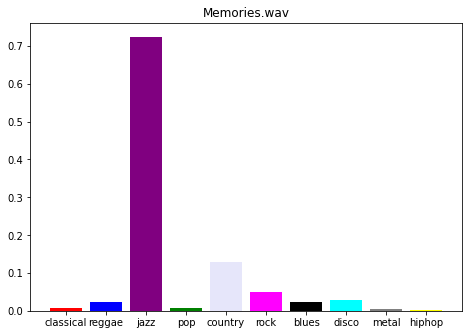

predictions_probabilities: [[9.9002248e-01 2.7294562e-05 5.9689027e-03 5.7999473e-06 1.9945651e-03
  4.7748963e-05 1.7362090e-03 1.7262889e-04 2.0813161e-05 3.5031821e-06]]
predicted genre: classical


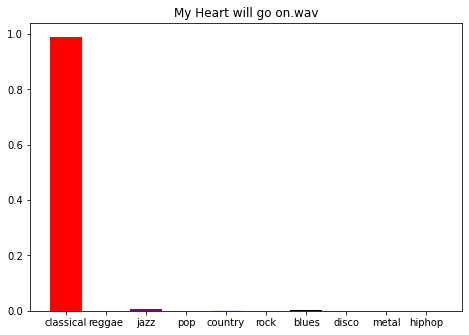

predictions_probabilities: [[9.4207531e-01 4.0209126e-03 1.6810931e-02 1.0475211e-03 4.6469821e-04
  7.4455235e-03 4.5933799e-04 4.9934853e-03 1.0681369e-02 1.2000782e-02]]
predicted genre: classical


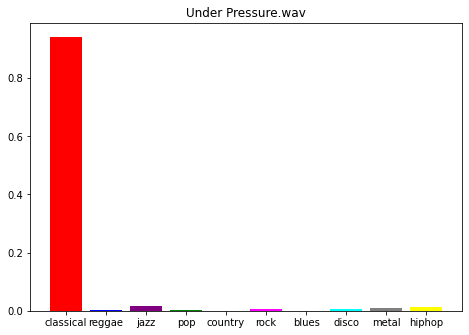

In [ ]:
test_sample_path='Memories.wav'
test(test_sample_path)
test_sample_path='My Heart will go on.wav'
test(test_sample_path)
test_sample_path='Under Pressure.wav'
test(test_sample_path)

**CONVOLUTIONAL NEURAL NETWORK**

In [ ]:
from keras.layers import Convolution2D, Conv2D, ReLU,MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 8
num_columns = 8
num_channels = 2

X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

filter_size = 3

# Construct model 
model = Sequential()
model.add(Conv2D(64, 3, input_shape= (num_rows, num_columns, num_channels)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(2))
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(ReLU())
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'sigmoid'))
model.add(Dense(10, 'softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 6, 6, 64)          1216      
_________________________________________________________________
batch_normalization_24 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 6, 6, 64)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 1, 32)          18464     
_________________________________________________________________
batch_normalization_25 (Batc (None, 1, 1, 32)          128       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 1, 1, 32)         

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_cnn.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.fit(X_train, y_train, batch_size=32, epochs=3000, validation_data=(X_test, y_test),callbacks = [model_checkpoint_callback],verbose=1)


Streaming output truncated to the last 5000 lines.
Epoch 70/3000
250/250 [==============================] - 2s 7ms/step - loss: 0.5333 - accuracy: 0.8978 - val_loss: 0.8939 - val_accuracy: 0.8178
Epoch 71/3000
250/250 [==============================] - 2s 6ms/step - loss: 0.4865 - accuracy: 0.9098 - val_loss: 1.1541 - val_accuracy: 0.7603
Epoch 72/3000
250/250 [==============================] - 2s 7ms/step - loss: 0.5423 - accuracy: 0.8921 - val_loss: 0.8941 - val_accuracy: 0.8158
Epoch 73/3000
250/250 [==============================] - 2s 7ms/step - loss: 0.4948 - accuracy: 0.9118 - val_loss: 0.8691 - val_accuracy: 0.8258
Epoch 74/3000
250/250 [==============================] - 2s 7ms/step - loss: 0.4825 - accuracy: 0.9104 - val_loss: 0.9087 - val_accuracy: 0.8043
Epoch 75/3000
250/250 [==============================] - 2s 7ms/step - loss: 0.4933 - accuracy: 0.9042 - val_loss: 0.9180 - val_accuracy: 0.8118
Epoch 76/3000
250/250 [==============================] - 2s 6ms/step - loss: 0.

In [ ]:
model = keras.models.load_model('model_cnn.h5')
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8678678870201111
